In [71]:
import numpy as np
import pandas as pd
import math
%pylab inline
import warnings
import os
import pickle

from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Функции предобработок (с предыдущих недель)

In [72]:
# фунция со второй недели: выбор тех регионов, из которых в среднем осущесвтляется больше 5 поездок
def chose_refions_with_rides(df):
    df.index = pd.to_datetime(df.index)
    
    # выделяем час из даты
    df['pickup_data'] = df.index
    df['pickup_hour'] = df['pickup_data'].dt.hour

    # число дней в месяце
    days_in_month = df['pickup_data'][0].days_in_month
    df = df.drop('pickup_data',axis = 1)
    # групируем число поездок по часам
    rides_in_hour =[]
    for i in range(0,24):
        rides_in_hour.append(df[df['pickup_hour']  == i].sum())

    df_hours = pd.DataFrame(rides_in_hour)
    df_hours = df_hours.drop('pickup_hour',axis = 1)
    
    means = df_hours.apply(np.mean)
    return np.array(means[(means/days_in_month > 5)].index)

In [73]:
# сведение всех данных в одну таблицу
def read_region_from_data(dataDir, start_year, start_month, last_year, last_month, columns):
    columns = np.append(columns,'Unnamed: 0')
    month = start_month
    year = start_year

    df = pd.DataFrame()
    while os.path.exists(dataDir + '/trip_count_%d-%02d.csv'% (year, month) ):  
        month_data = pd.read_csv(dataDir + '/trip_count_%d-%02d.csv' % (year, month), usecols = columns)       
        month_data.set_index(['Unnamed: 0'], inplace=True)
        
        df = pd.concat((df,month_data), axis = 0)

        # Return on last month and year
        if (month == last_month and year == last_year):
            df.index.name = 'time'
            df.index = pd.to_datetime(df.index)
            return df

        # Increment month
        if (month == 12):
            month = 1
            year += 1
        else:
            month += 1
        

### 2 Получение итоговой таблицы поездок
(с вычетом непопулярных регионов за май 2016г)


In [129]:
filename = 'trip_count_2016-05.csv'
dataFolder = 'trips'
    
df = pd.read_csv(dataFolder+ '/' + filename, index_col = 0)
df.index = pd.to_datetime(df.index)
region_columns = chose_refions_with_rides(df)

In [130]:
data = read_region_from_data('trips', 2015, 8, 2016, 5, region_columns)

In [131]:
data

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2015-08-01 00:00:00,64,118,66,94,260,368,566,786,957,207,...,8,1,9,108,111,112,15,142,54,55
2015-08-01 01:00:00,49,93,30,62,195,347,630,883,1165,221,...,17,0,0,4,5,70,11,119,5,25
2015-08-01 02:00:00,56,74,13,40,145,299,585,763,1232,237,...,12,0,1,0,0,3,2,26,19,4
2015-08-01 03:00:00,21,61,4,25,124,244,369,462,1193,209,...,5,0,0,1,1,3,0,16,0,0
2015-08-01 04:00:00,7,11,4,20,105,138,168,287,651,104,...,20,0,0,3,1,1,0,7,1,9
2015-08-01 05:00:00,9,15,4,6,38,56,62,94,133,17,...,13,0,1,7,7,30,5,76,19,49
2015-08-01 06:00:00,11,30,23,19,56,52,58,74,79,39,...,7,1,1,8,3,44,7,198,23,82
2015-08-01 07:00:00,11,50,38,30,85,70,79,134,84,33,...,8,0,2,25,8,60,4,122,45,47
2015-08-01 08:00:00,22,88,41,28,136,103,129,152,154,53,...,11,1,4,110,39,73,2,103,8,79


### 2 Стандартизация
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [132]:
norm_mean_std = []
data_normed = data.copy()

for col in data.columns:
    mean = data_normed[col].mean()
    std = data_normed[col].std()
    norm_mean_std.append([mean, std])
                          
    data_normed[col] = (data_normed[col] - mean) / std

### 3 Кластеризация географических зон по значениям стандартизованных рядов. 

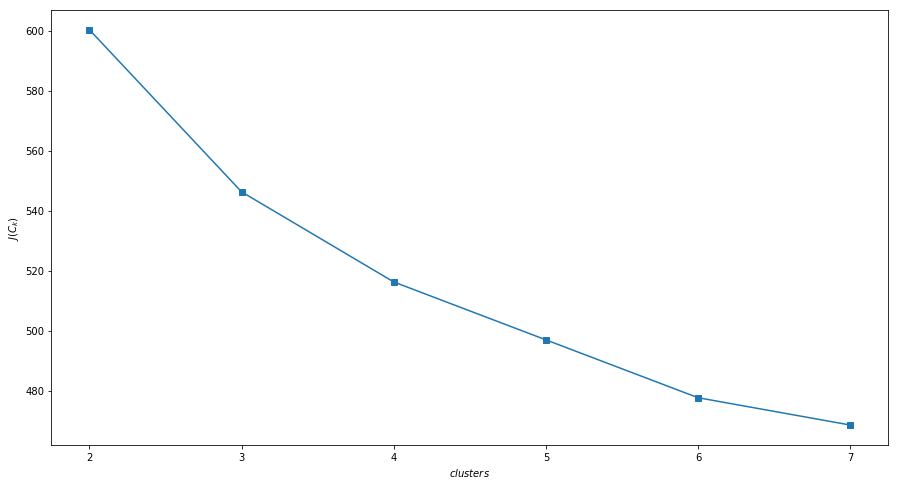

In [133]:
#для кластеризации транспонируем таблицу
data_normed_T = data_normed.T.copy()

# суммы дистанций от элементов до их соотве. кластеров
inertia = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normed_T)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 8), inertia, marker='s');
plt.xlabel('$clusters$')
plt.ylabel('$J(C_k)$');

По графику видно, что функция быстро убывает в начале (2-3) кластера, затем это происходит менее быстро.
Выберем число кластеров, ранвое 3. Вприницпе, если вспомнить карту со второй недели, это будет оправдано.

Распределим регионы по нашим кластерам.

In [134]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit_predict(data_normed_T)

data_normed_T['cluster'] = kmeans.labels_
data_normed_T['cluster'].value_counts()

1    53
2    26
0    23
Name: cluster, dtype: int64

А теперь разобъём наш датафрейм по кластерам для дальнейшей работы по-отдельности

In [135]:
df_clusters = []

for n in range(n_clusters):
    df_clusters.append(data_normed_T[data_normed_T['cluster'] == n].T)

Убедимся, что данные по кластерам схожи.

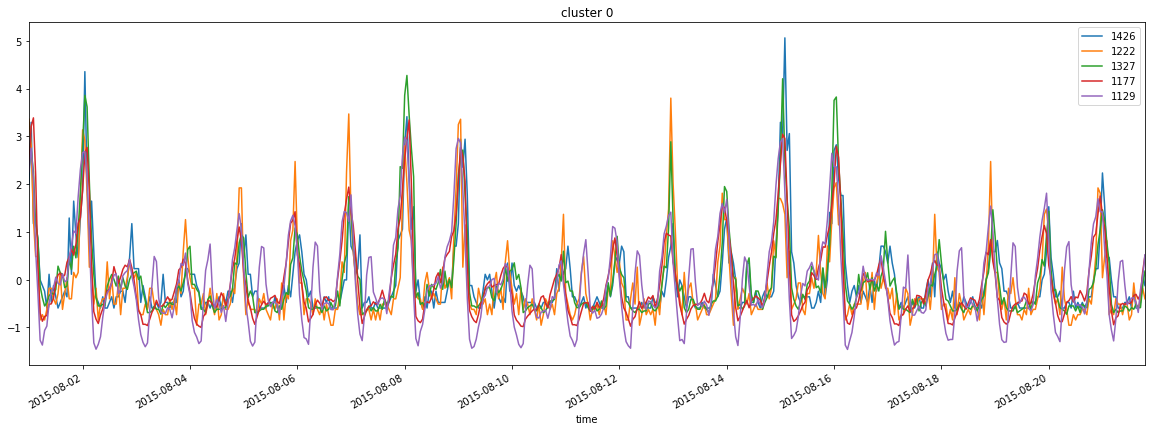

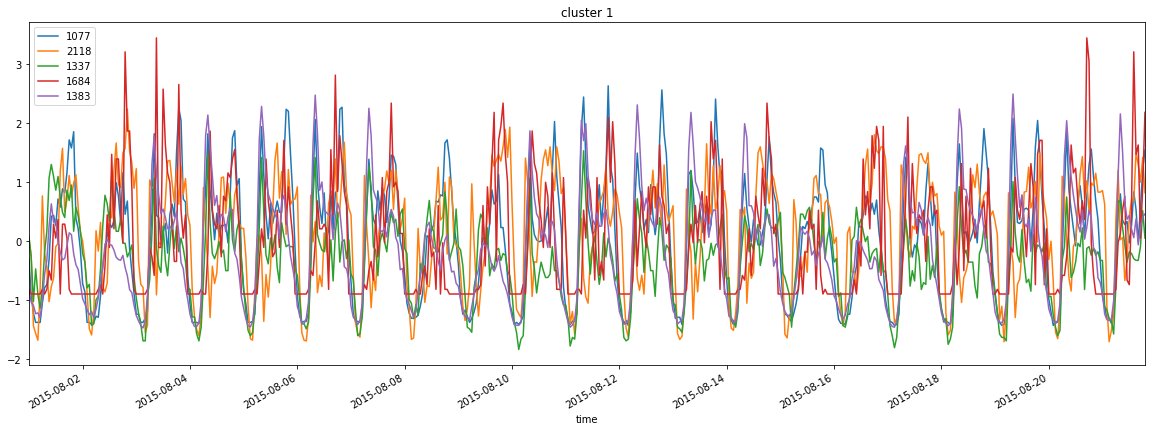

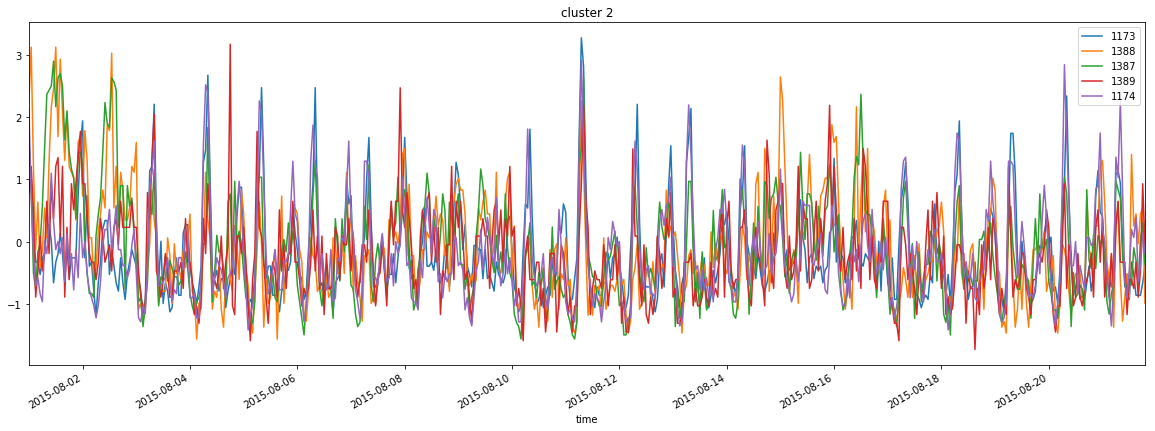

In [136]:
for i in range(n_clusters):
    columns = df_clusters[i].columns
    usecols = np.random.choice(columns, 5)
        
    df_clusters[i][usecols][0:500].plot(figsize =(20,7))
    plt.title('cluster ' + str(i))
    plt.show()

Как видно, разница между кластерами есть, внутри структура более-менее одинаковая

### 4 В каждом кластере выберем наиболее типичный ряд 
(возьмём ряд, соответствующий центру кластера)

In [137]:
df_cluster_centers = pd.DataFrame(index=data_normed.index)
for i in range(n_clusters):
    df_cluster_centers['cluster' + str(i)] = kmeans.cluster_centers_[i]
    
df_cluster_centers.head()

,cluster0,cluster1,cluster2
time,,,
2015-08-01 00:00:00,2.295539,0.090178,1.035782
2015-08-01 01:00:00,2.704540,-0.376051,1.115361
2015-08-01 02:00:00,2.432252,-0.736199,0.399809
2015-08-01 03:00:00,1.315245,-0.941890,-0.215083
2015-08-01 04:00:00,0.528265,-1.160953,0.073102


In [138]:
# для удаления недельных трендов
def add_week_cycle_features(original_dataframe, k, inplace=False):
    if inplace:
        df = original_dataframe
    else:
        df = original_dataframe.copy()
    T = original_dataframe.shape[0]
    for i in range(1, k + 1):
        df["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
        df["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    if not inplace:
        return df

In [139]:
# признаки, отвечающие за дни недели
def add_day_of_week_features(original_dataframe, k, inplace=False):
    if inplace:
        df = original_dataframe
    else:
        df = original_dataframe.copy()
        
    for dow in range(7):
        df['dow_%d' % dow] = 0
        df.loc[df.index.dayofweek == dow, ['dow_%d' % dow]] = 1
        
    if not inplace:
        return df      

In [140]:
# разбиение данных
def split_data(df_region):
    cols = df_region.columns[1:]
    X = df_region[cols].values
    y = df_region['trips'].values  
    return X,y,cols

In [141]:
# огбучение модели Линейной регрессии
def train_lr(X,y):
    model = LinearRegression()
    model.fit(X, y)
    return model

https://www.researchgate.net/post/What_is_the_AIC_formula

In [142]:
# вычисление AIC
def calc_AIC(model, X, y, k, N):
    y_pred = model.predict(X)
    resid = y - y_pred
    sse = sum(resid ** 2)
    AIC = 2 * k + N * np.log(sse / N)
    return AIC

In [143]:
# общая функция создания регрессионных признаков
def make_regression_features(df_region):
    
    T = df_region.shape[0]

    best_aic = float("inf")
    best_cols = []
    best_k = 2
    aics = []

    for k in range(4,7):

        # regression features
        add_week_cycle_features(df_region, k, inplace = True)
        add_day_of_week_features(df_region, k, inplace = True)
        X,y,cols = split_data(df_region)
        
        # model
        lr_model = train_lr(X,y)

        # Calc AIC
        N = T        
        AIC = calc_AIC(lr_model,X,y, k, N)

        if AIC < best_aic:
            best_aic = AIC
            best_cols = cols.copy()
            best_k = k

        aics.append(AIC)

    print("Best AIC = %.4f" % best_aic)
    print("Best K = %d" % best_k)
    print("Best columns = %s" % best_cols)
    
    return best_k, best_cols

In [144]:
df_regions = []
best_ks = []
best_columns = []

for n in range(n_clusters):
    df_region = pd.DataFrame(df_cluster_centers['cluster%d'%n].copy(), index = df_cluster_centers.index)
    df_region.columns = ['trips']

    # формальность, ибо какое К не задавай, он выбирает его, так что по сути best_cols = cols.
    best_k, best_cols = make_regression_features(df_region)

    df_regions.append(df_region)
    best_ks.append(best_k)
    best_columns.append(best_cols)

Best AIC = -5150.9614
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')
Best AIC = -3598.8475
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')
Best AIC = -6219.6117
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')


In [145]:
# построение остатков для ряда
def make_residuals(df, best_cols, begin_time, end_time):
    
    lr_model = train_lr(df[best_cols].values, df['trips'].values)

    predictions = lr_model.predict(df[best_cols])
    resid = df['trips'].values - predictions

    plt.figure(figsize=(20,7))
    
    # ogigin data
    df.loc[begin_time : end_time,'trips'].plot(label='origin_trips')   
    
    # resids
    df_resid = pd.DataFrame(resid, columns=['residuals'], index=df.index)
    df_resid.loc[begin_time : end_time,'residuals'].plot(color='y')

    # predictions
    df_pred = pd.DataFrame(predictions, columns=['predictions'], index=df.index)
    df_pred.loc[begin_time : end_time, 'predictions'].plot(color='r')

    sm.tsa.seasonal_decompose(df.loc[begin_time : end_time,'trips']).trend.plot(label = 'season_decompose')
    plt.legend(loc=1,prop={'size':16})
    return df_resid, df_pred

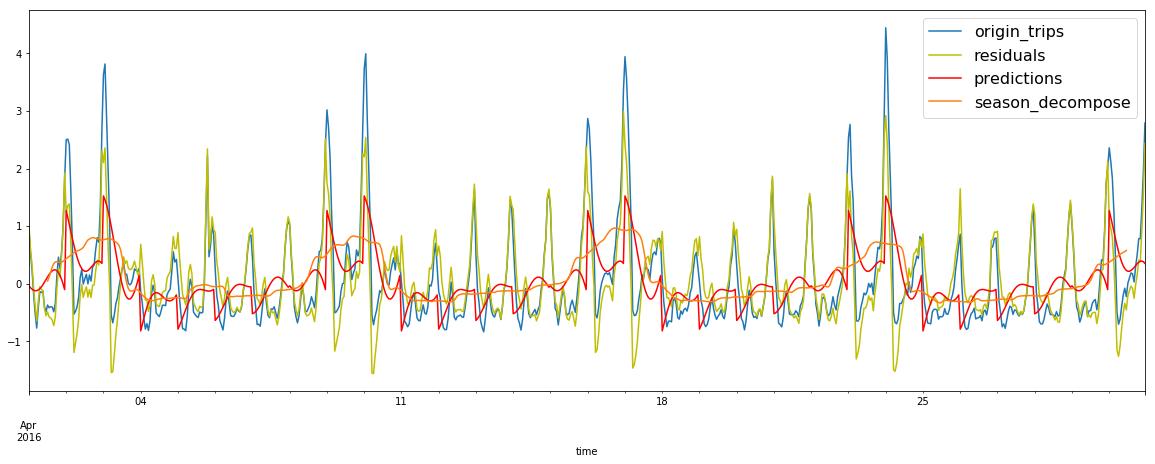

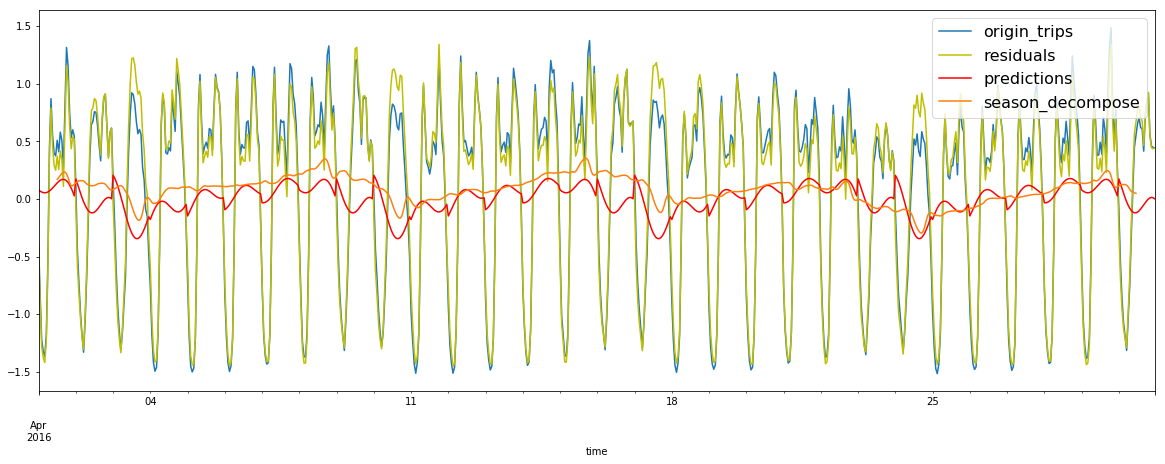

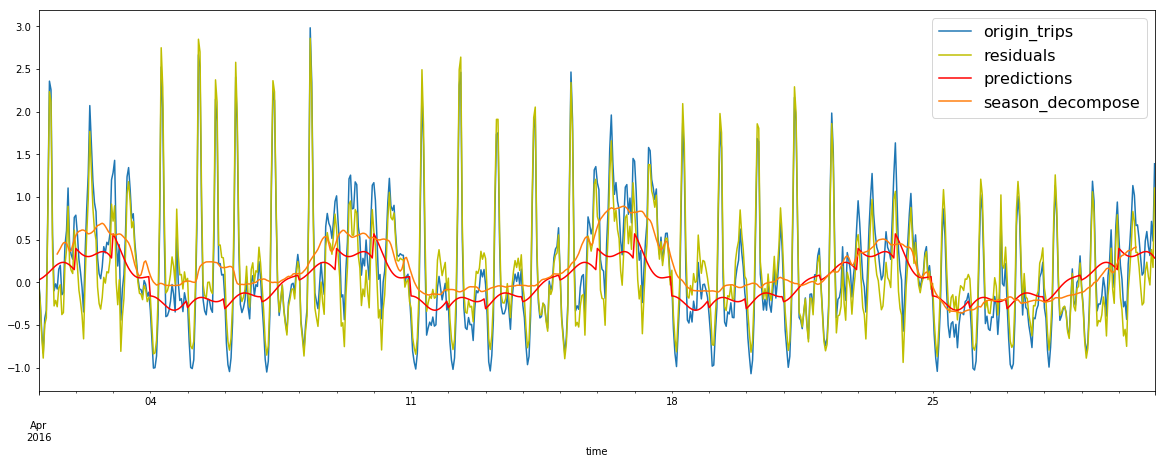

In [146]:
residuals = []
predictions = []
for n_cluster in range(n_clusters):
    begin_time = '2016-04-01 00:00:00'
    end_time = '2016-04-30 23:00:00'
    resids, preds = make_residuals(df_regions[n_cluster], best_columns[n_cluster], begin_time, end_time)
    
    residuals.append(resids)
    predictions.append(preds)

По графикам видно, что линейная регрессия неплохо описывает STL декомпозицию.

Проведём сезонное дифференцирование. Как показывала 3 неделя, одного преобразования было достаточно для получения стационарного ряда.

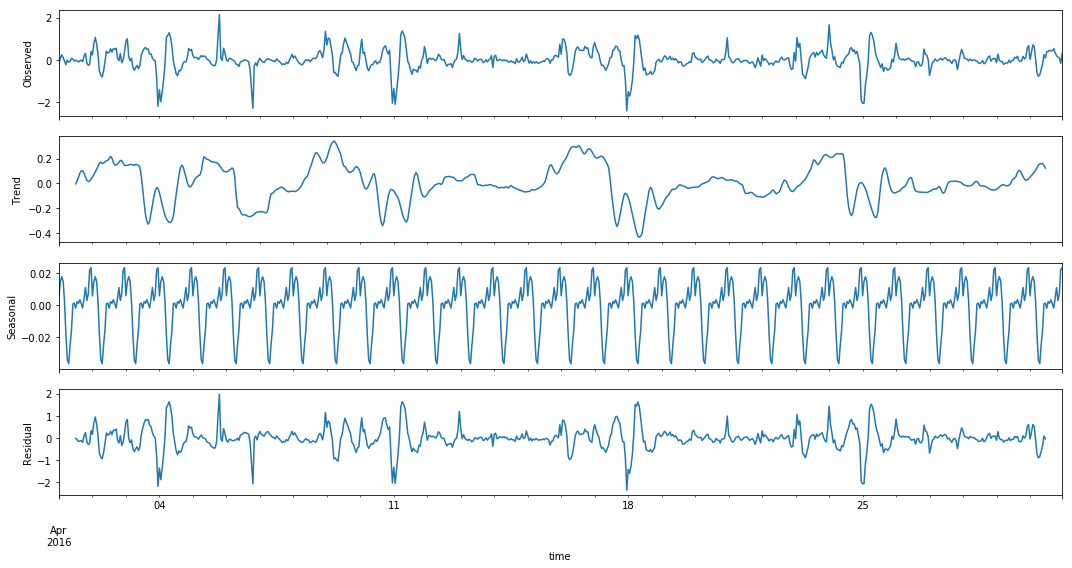

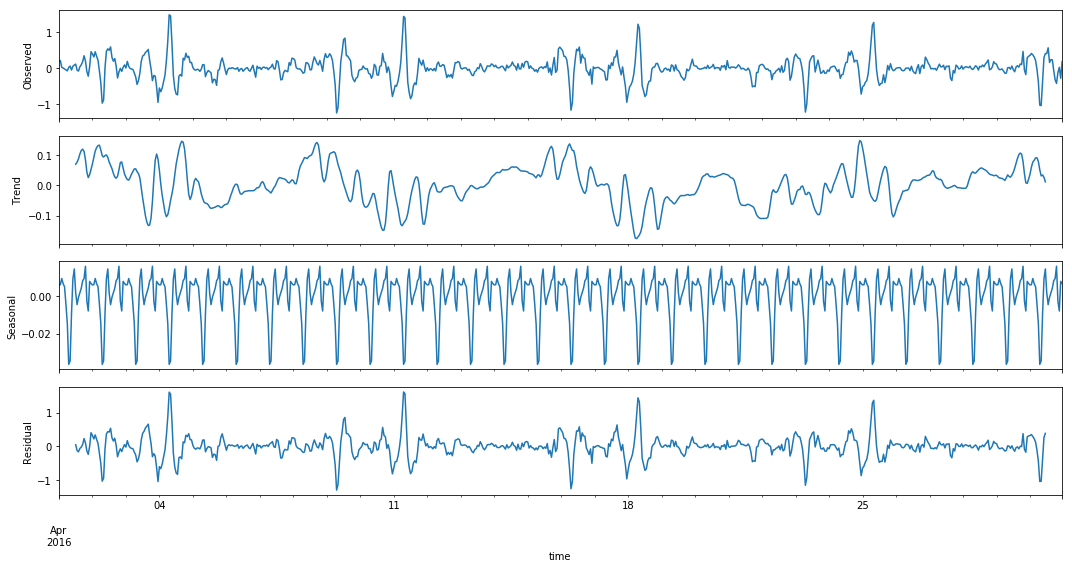

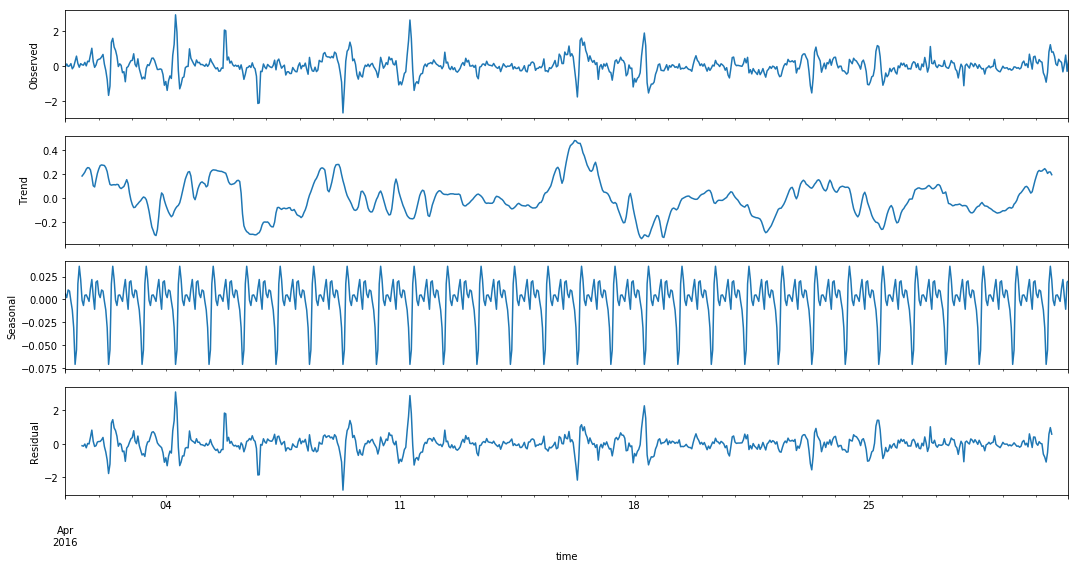

In [147]:
def make_season_diff(df_resid, begin_time, end_time):
    df_resid['diff_24'] = df_resid.residuals - df_resid.residuals.shift(24)

    plt.figure(figsize(15,8))
    sm.tsa.seasonal_decompose(df_resid.loc[begin_time:end_time,'diff_24']).plot()
    plt.show()
    
    return df_resid
    
residuals_diff24 = []
for n in range(n_clusters):
    resid_diff24 = make_season_diff(residuals[n],begin_time,end_time )
    residuals_diff24.append(resid_diff24)

In [148]:
def plot_acf_pacf(df):
    plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(df['diff_24'][24:].values.squeeze(), lags=168, ax=ax)
    plt.show()
    
    plt.figure(figsize=(15,8))
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(df['diff_24'][24:].values.squeeze(), lags=168, ax=ax)
    plt.show()

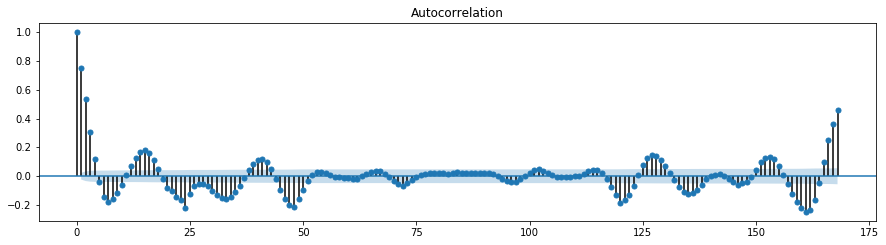

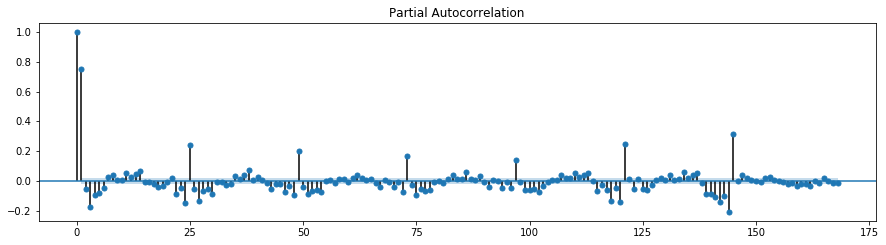

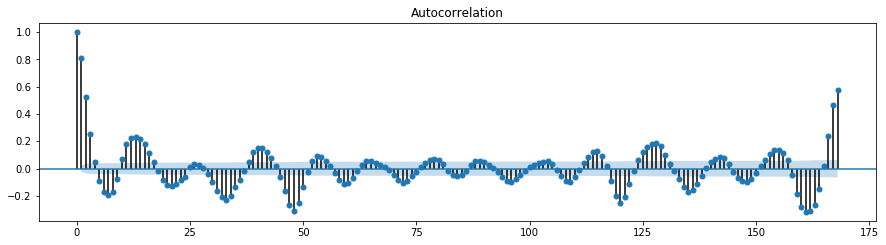

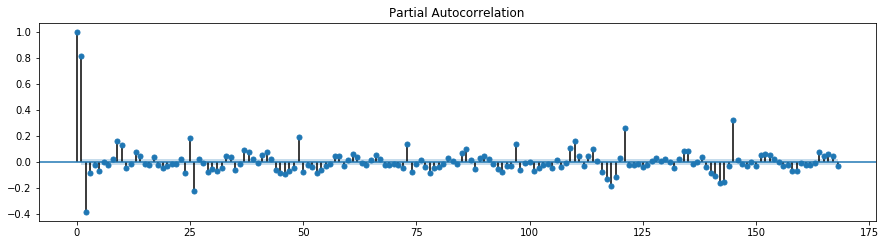

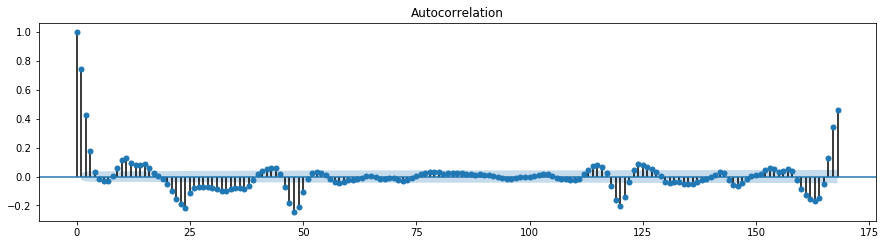

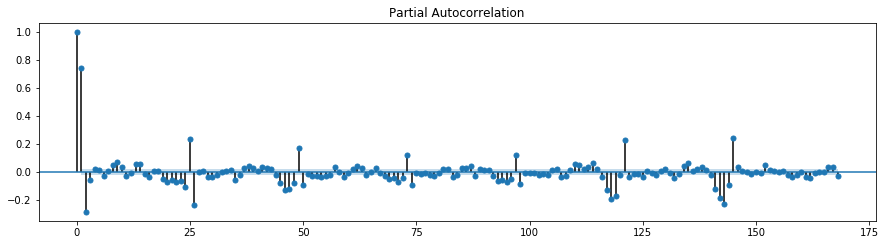

In [149]:
for n in range(n_clusters):
    plot_acf_pacf(residuals_diff24[n])

Параметры возьмём приближёнными для скорости, но в ущерб качеству

In [150]:
from itertools import product

hyper_params = []

hyper_params.append({'p':1, 'q':2, 'P':1, 'Q':1})
hyper_params.append({'p':1, 'q':2, 'P':1, 'Q':2})
hyper_params.append({'p':2, 'q':2, 'P':1, 'Q':1})

### 5.Построение модели

In [151]:
# основная функцию по оптимальной модели
def train_SARIMAX(data, begin_time, end_time, cluster, parameters):
    warnings.filterwarnings('ignore')

    best_aic = float('inf')
    time_data = data.loc[begin_time:end_time, 'residuals']
    
    ps = range(0, hyper_params[n]['p']+1)
    d  = 0 # одно обычное дифференцирование
    qs = range(0, hyper_params[n]['q']+1)
    Ps = range(0, hyper_params[n]['P']+1)
    D  = 1 # одно сезонное дифференцирование
    Qs = range(0, hyper_params[n]['Q']+1)

    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    print(len(parameters_list))
    
    if not os.path.exists('models'):
        os.mkdir('models')
          
    for param in parameters_list:

        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(time_data, order=(param[0], d, param[1]), 
                                            enforce_stationarity=False,
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
                                        
            
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
   
    return best_model, best_param

In [152]:
%%time
begin_time = '2016-03-30 00:00:00'
end_time ='2016-04-30 23:00:00'
models = list()
params = list()
for n in range(n_clusters):
    model, param = train_SARIMAX(residuals[n],begin_time,end_time, n, hyper_params[n])
    models.append(model)
    params.append(param)             

24
wrong parameters: (0, 0, 0, 0)
36
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 0, 2)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 1, 1, 2)
36
wrong parameters: (0, 0, 0, 0)
Wall time: 7min 21s


In [153]:
for n in range(n_clusters):
    with open('models/model_residuals_%d.pkl'%n, 'wb') as model_pkl:
         pickle.dump(models[n], model_pkl)    
    

TypeError: can't pickle statsmodels.tsa.statespace._statespace.dStatespace objects

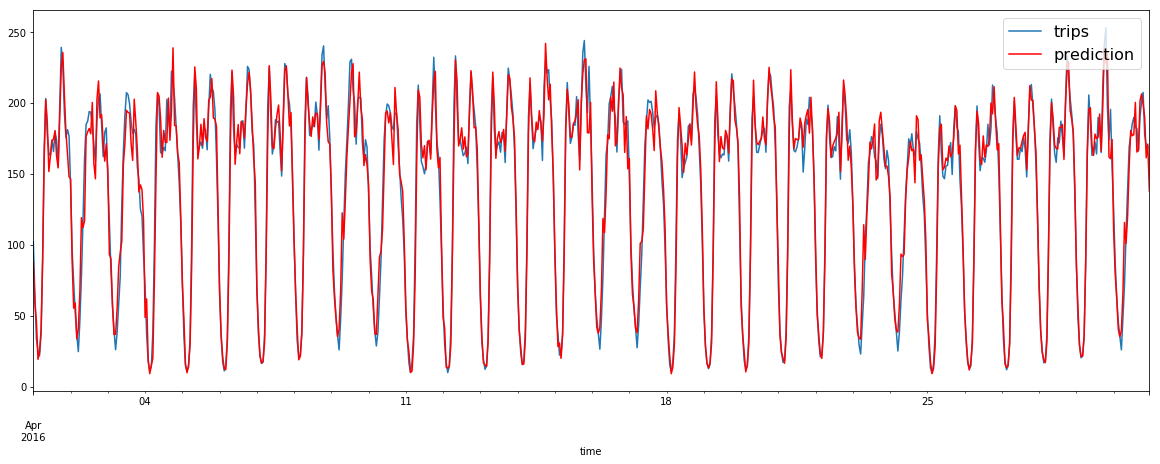

In [154]:
# проверка модели
cluster = 1
begin_time = '2016-04-01 00:00:00'
end_time = '2016-04-30 23:00:00'
cl_center = df_cluster_centers.loc[begin_time:end_time , 'cluster%d'%cluster]
df = pd.DataFrame(cl_center * norm_mean_std[cluster][1] + norm_mean_std[cluster][0])
df.columns = ['trips'] 
df['prediction'] = (models[cluster].fittedvalues.loc[begin_time:end_time].values + 
                    predictions[cluster].loc[begin_time:end_time].predictions) * norm_mean_std[cluster][1] + norm_mean_std[cluster][0]

plt.figure(figsize=(20,7))
df.trips.plot()
df['prediction'].plot(color = 'r')
plt.legend(loc=1,prop={'size':16})
plt.show()

### 6.Прогнозизование и ошибки модели

In [155]:
def calc_mae(initial_month_time, end_date, hours, df_predictions):

    results = list()  
    region_sum = 0
    
    for index, r in enumerate(region_columns):
                
        # учаем номер кластера, соответствующего региону
        region_cluster = int(data_normed_T.loc[r, 'cluster'])
        
        mean = norm_mean_std[index][0]
        std = norm_mean_std[index][1]
        
        # модель для региона с  парметрами кластера
        data_r = data_normed.loc[initial_month_time : end_date[0], r]
#         data_r = data_normed.loc['2016-04-01 00:00:00':history_ends[0],'r%d'%r]
        region_model = sm.tsa.statespace.SARIMAX(data_r,  
                                            order=(1,0,2), 
                                            seasonal_order=(1,1,1, 24)).filter(models[region_cluster].params) 
    
        df_region_pred = region_model.predict(str(end_date[0]), str(end_date[-1]))

        df_region_pred = df_region_pred - df_region_pred.mean()
        
        hist_sum = 0
        y_sum = 0
        for h in range(1, (hours + 1)):

                label = end_date[h-1]
                start_time = datetime.strptime(str(end_date[0]), "%Y-%m-%d %H:%M:%S") + timedelta(hours=h)
                end_time = start_time + timedelta(hours=5)
                
                y = data_normed.loc[start_time:end_time, r].values  

                y_pred = df_region_pred.loc[start_time:end_time].values
                
                preds = df_predictions[region_cluster].loc[start_time:end_time].predictions.values
                y_pred2 = (y_pred + preds)
                
                try:
                    for h in range(0,6):
                        #собираем результат для сабмишена
                        results.append([
                            "%d_%d-%02d-%02d_%d_%d" %(r, label.year, label.month, label.day, label.hour, (h+1)),
                            y_pred2[h] * std + mean,
                            y[h] * std + mean])
                
                
                    y_sum = np.abs((y_pred2 * std + mean) - (y * std + mean)).sum()
                except:
                    continue
#                     print(r, y, y_pred, region_cluster, start_time, end_time)
                    
                hist_sum += y_sum

        region_sum += hist_sum

    #считаем общую ошибку
    return region_sum / (102 * hours * 6), results

In [156]:
df_raw_may = data_normed.loc['2016-04-30 23:00:00': '2016-05-31 23:00:00']
may_hist_ends = list(df_raw_may.index)


mae_may, results_may = calc_mae('2016-04-01 00:00:00', may_hist_ends, 739, predictions)

print(mae_may)

0.0


In [ ]:
%%time

df_raw_june = data_normed.loc['2016-05-31 23:00:00': '2016-06-30 23:00:00']
june_hist_ends = list(df_raw_june.index)
mae_june, results_june = calc_mae(june_hist_ends, 715, predictions)

print(mae_june)